<a href="https://colab.research.google.com/github/oddgai/tensorflow_tutorial/blob/main/notebooks/cat_or_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 犬猫画像分類

https://www.tensorflow.org/tutorials/images/classification?hl=ja

In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

データのダウンロード

In [ ]:
# Kaggle の Dogs vs Cats データセットを使用
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [ ]:
train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

In [ ]:
train_cats_dir = os.path.join(train_dir, "cats")  # 学習用の猫画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, "dogs")  # 学習用の犬画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, "cats")  # 検証用の猫画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, "dogs")  # 検証用の犬画像のディレクトリ

In [ ]:
# 画像数
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("訓練猫:", num_cats_tr)
print("訓練犬:", num_dogs_tr)

print("検証猫:", num_cats_val)
print("検証犬:", num_dogs_val)
print("--")
print("合計猫:", total_train)
print("合計犬:", total_val)

訓練猫: 1000
訓練犬: 1000
検証猫: 500
検証犬: 500
--
合計猫: 2000
合計犬: 1000


データを学習できる形にする

下の全部を`ImageDataGenerator`がやってくれる

```
1. ディスクから画像を読み取ります。
2. これらの画像のコンテンツをデコードし、RGB値にしたがって適切なグリッド形式に変換します。
3. それらを浮動小数点テンソルに変換します。
4. ニューラルネットワークは小さな入力値を扱う方が適しているため、テンソルを0〜255の値から0〜1の値にリスケーリングします。
```

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)  # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255)  # 検証データのジェネレータ

In [ ]:
# パラメータの設定
batch_size = 128
IMG_HEIGHT = 150
IMG_WIDTH = 150

# ディスクから画像をロードしてリサイズする
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="binary")

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


データの可視化

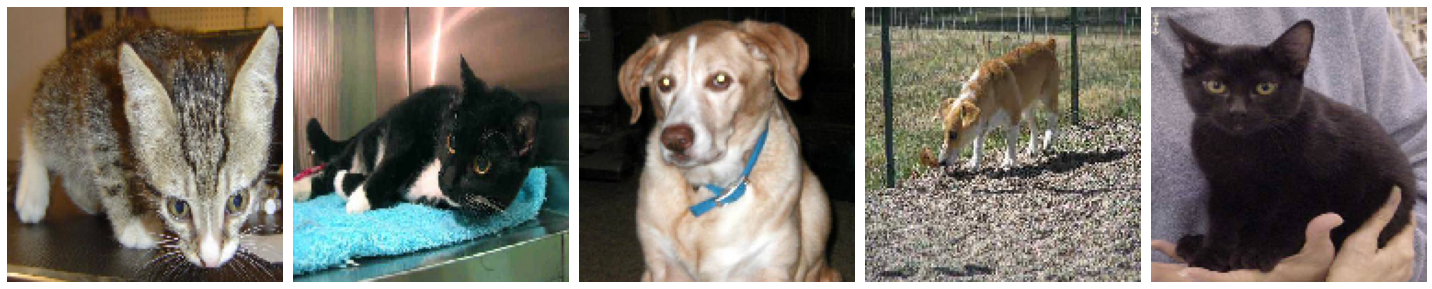

In [ ]:
def plotImages(images_arr):
    if len(images_arr) == 1:
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(images_arr[0])
        plt.axis("off")
    else:
        fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
        axes = axes.flatten()
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

モデル構築

* Conv2D: 2次元畳み込み層（入力が3次元なら出力も3次元を返す）
* MaxPooling2D: 縦横の空間を小さくする（2x2とかの領域を1マスにまとめる、4マスの最大値をとるならMaxPooling）

In [ ]:
model = Sequential([
    # 3x3のフィルタを16枚使う, padding="same"は入出力で画像サイズが変わらないようにする
    Conv2D(16, 3, padding="same", activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1, activation="sigmoid")  # 2値分類なのでsigmoid
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

トレーニング

データが`generator`なので`ImageDataGenerator`クラスの`fit_generator`を使う？

In [ ]:
epochs = 15
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
15/15 [==============================] - 10s 646ms/step - loss: 0.6947 - accuracy: 0.5347 - val_loss: 0.6863 - val_accuracy: 0.5167
Epoch 2/15
15/15 [==============================] - 9s 603ms/step - loss: 0.6803 - accuracy: 0.5956 - val_loss: 0.6709 - val_accuracy: 0.5547
Epoch 3/15
15/15 [==============================] - 9s 602ms/step - loss: 0.6452 - accuracy: 0.6330 - val_loss: 0.6434 - val_accuracy: 0.6496
Epoch 4/15
15/15 [==============================] - 9s 645ms/step - loss: 0.5941 - accuracy: 0.6976 - val_loss: 0.6183 - val_accuracy: 0.6730
Epoch 5/15
15/15 [==============================] - 9s 620ms/step - loss: 0.5350 - accuracy: 0.7393 - val_loss: 0.5885 - val_accuracy: 0.6953
Epoch 6/15
15/15 [==============================] - 9s 628ms/step - loss: 0.4669 - accuracy: 0.7842 - val_loss: 0.7112 - val_accuracy: 0.6518
Epoch 7/15
15/15 [==============================] - 9s 634ms/step - loss: 0.4441 - accuracy: 0.8018 - val_loss: 0.6094 - val_accuracy: 0.6819
Epoch

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

NameError: ignored

過学習してるので改善

* 画像が少ないので学習用データをかさ増しする
* ドロップアウト層も追加する

Found 2000 images belonging to 2 classes.


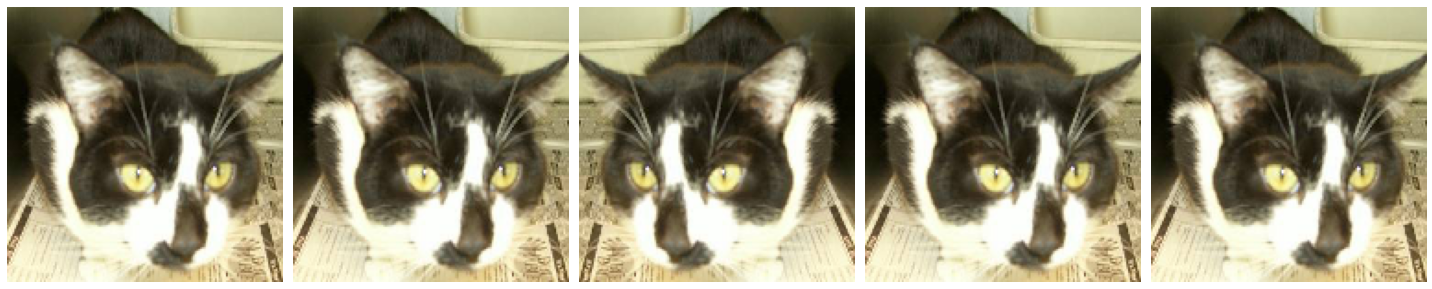

In [ ]:
# ランダムに水平反転させる
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


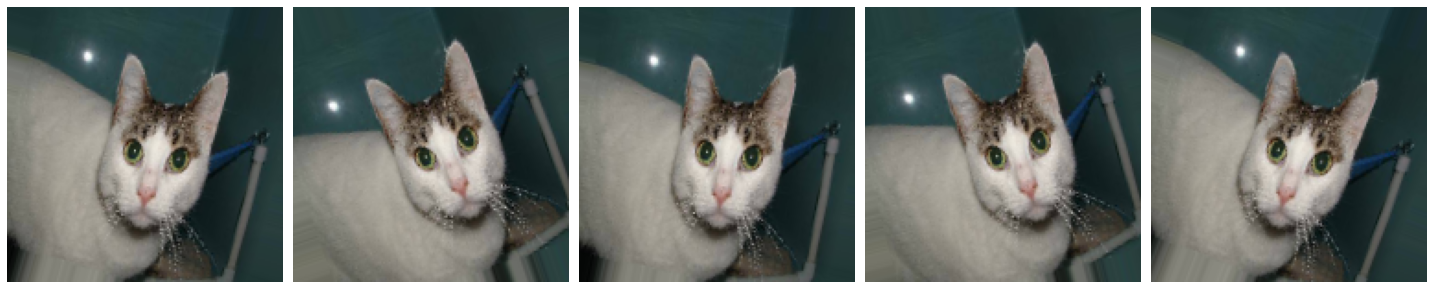

In [ ]:
# ランダムに回転させる
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)  # 左右45度
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


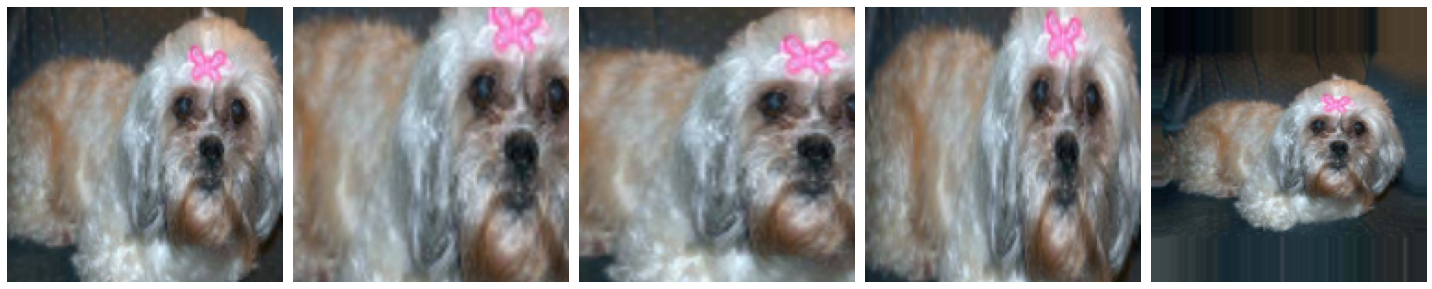

In [ ]:
# ズーム
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


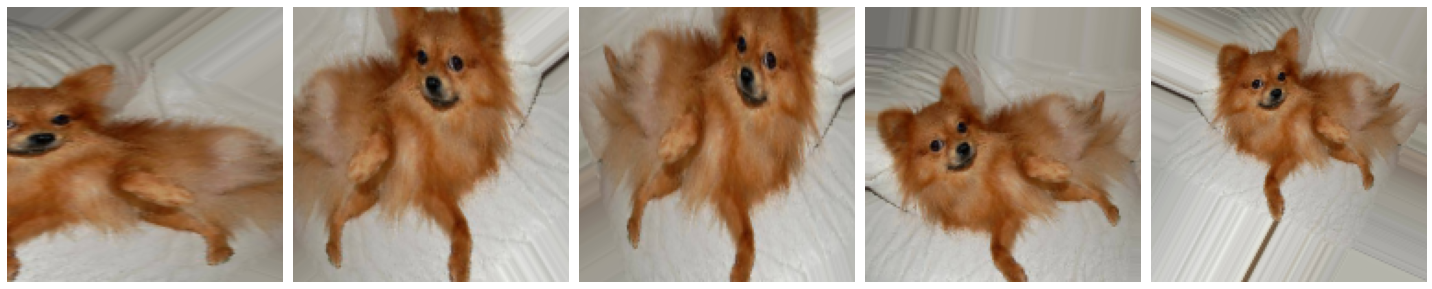

In [ ]:
# 水平反転、回転、ズームを全部やる
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=0.15,  # 画像を一定割合だけずらすのを許可する（横にずらす）
                    height_shift_range=0.15,  # 画像を一定割合だけずらすのを許可する（縦にずらす）
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="binary")
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
# 検証用データは普通にやる
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode="binary")

Found 1000 images belonging to 2 classes.


In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding="same", activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [ ]:
model_new.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
epochs = 15
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
15/15 [==============================] - 22s 1s/step - loss: 1.3553 - accuracy: 0.5048 - val_loss: 0.6934 - val_accuracy: 0.4967
Epoch 2/15
15/15 [==============================] - 19s 1s/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6930 - val_accuracy: 0.5134
Epoch 3/15
15/15 [==============================] - 18s 1s/step - loss: 0.6931 - accuracy: 0.5283 - val_loss: 0.6925 - val_accuracy: 0.5335
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.6928 - accuracy: 0.5075 - val_loss: 0.6907 - val_accuracy: 0.5324
Epoch 5/15
15/15 [==============================] - 18s 1s/step - loss: 0.6930 - accuracy: 0.5069 - val_loss: 0.6917 - val_accuracy: 0.5357
Epoch 6/15
15/15 [==============================] - 19s 1s/step - loss: 0.6905 - accuracy: 0.5475 - val_loss: 0.6871 - val_accuracy: 0.5502
Epoch 7/15
15/15 [==============================] - 18s 1s/step - loss: 0.6841 - accuracy: 0.5572 - val_loss: 0.6903 - val_accuracy: 0.5480
Epoch 8/15
15/15 [==

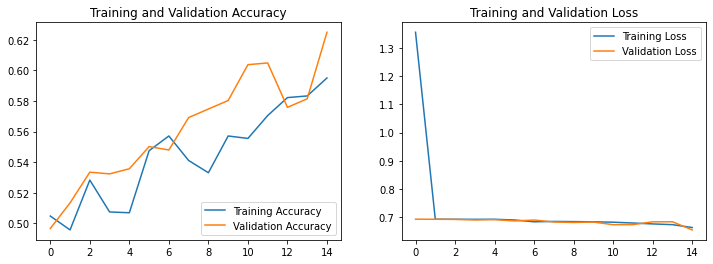

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

学び
* 画像の読み込みは`ImageDataGenerator`とかいろんな方法がありそう
* 画像の反転、回転、拡大縮小など教師データのかさ増しで過学習を防げるかもしれない